# The script within the Cloud Function explained

Hello there!
Here you can find the process I did in detail. 

- Part 0: Where this data comes from? You can find it in the Readme.
- Part I: Once I have the 4 datasets, I need to merge them into 1.
- Part II: Process the final dataset to leave it as I want for ML
- Part III: Normalization and ML

I like to divide the problem into several scripts, it's easier for me to solve problems while debugging in this way, so you will find that a csv is saved in the *tmp* folder, and loaded again in the next cell (It's just I copypasted my code here, and I'm not going to rename variables or refactorize just for a non-paid explanation :D )

I hope you find it useful and enjoyable

-------------------------------------------------

# PART I

-----------------------

# Creating the dataset to play with.

- Merge 4 datasets with different lenght by date
- Google searches dataset:
    - There are 3 columns: Date, keywords, and score, grouped by week. It needs to be structured like a column for each keyword, and rows with the score (the score will be the trend index of Google Trends).
    
- Spanish news (3 datasets):
    - There are 3 columns: Date, keyword and sentiment. The same keyword can appear many times the same day.
    - A column counting occurrences per day of a keyword must be created, also a column with mean sentiment per day.
    - Then a column called score will be created, multiplying occurrences * mean.
    - Then the final datset will be Date, as much columns as keywords, every column will have the score mentioned above as rows. Everything grouped by week.

In [1]:
import pandas as pd

In [2]:
df_political=pd.read_csv("./input/dashboard_spanish_news_political.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_political.sort_values(by=["Date"],inplace=True)

df_economical=pd.read_csv("./input/dashboard_spanish_news_economical.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_economical.sort_values(by=["Date"],inplace=True)

df_social=pd.read_csv("./input/dashboard_spanish_news_social.csv.gz",compression='gzip', header=0, quotechar='"', error_bad_lines=False)
df_social.sort_values(by=["Date"],inplace=True)

df_google=pd.read_csv("./input/data_pytrends.csv",index_col=[0])
df_google.sort_values(by=["date"],inplace=True)

# Dataset previews:

- With news, I need to count occurrences, calculate the average of sentiment, multiply both to create a new column.


In [3]:
df_political.head()

,political,Date,Sentiment
15972,juicio,2019-01-01,0.18
32039,protestas,2019-01-01,5.06
24844,ejercito,2019-01-01,-2.64
24845,ejercito,2019-01-01,-2.64
24846,ejercito,2019-01-01,-3.27


- With Google searches, what we have is the Trending index. Score 100 means that from the requested period of time, in this week the maximum of occurrences were reached, and everything else get normalize by that peak. It is not possible to request the real number of occurrences.

In [4]:
#df_google.drop(columns='Unnamed: 0', inplace=True)
df_google.head()

,keyword,date,trend_index
0,zoom,2019-01-06,5
1919,mas pais,2019-01-06,17
6262,steam,2019-01-06,43
2727,cursos online,2019-01-06,26
5454,residencia ancianos,2019-01-06,29


# Working with the Google dataset: 

- Creating a column for each keyword with the trend_index value.

I'm going to create a dataframe with the set of dates, and append the score of keywords to this dataset (kind of get dummies, but I can't do that, I have already the units I want for each column)

In [5]:
# creating df
df_google_dates=pd.DataFrame()

# creating the Date column in new dataset
df_google_dates["date"]=list(set(df_google["date"]))
df_google_dates["date"]=pd.to_datetime(df_google_dates["date"])
df_google_dates.sort_values(by=["date"],inplace=True)
df_google_dates.head()

,date
68,2019-01-06
95,2019-01-13
88,2019-01-20
93,2019-01-27
52,2019-02-03


In [6]:
# dates are a pain in the ass, you know right?
df_google_dates.date.dtypes

dtype('<M8[ns]')

 - append to the empty dataframe with dates

In [7]:
# Creating the new columns. Trend index with the name of the corresponding keyword
keyword_list=list(set(df_google["keyword"]))
keyword_list.sort()
for k in keyword_list:
    df_google_dates[k]=df_google[(df_google['keyword'] == k)]["trend_index"].tolist()
#df_google_dates.index=df_google_dates["date"]
#df_google_dates.drop(columns="date",inplace=True)
df_google_dates.head()

,date,amazon,autonomo,ayuda alquiler,badi,banco alimentos,barometro,bildu,bullying,cabify,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
68,2019-01-06,59,42,38,54,4,62,4,22,22,...,44,2,57,27,11,3,3,34,46,5
95,2019-01-13,50,47,26,45,2,25,5,22,28,...,52,2,48,34,14,2,2,25,44,4
88,2019-01-20,44,38,20,52,1,23,3,24,100,...,100,3,47,100,11,5,2,16,44,4
93,2019-01-27,46,53,20,64,3,56,4,32,67,...,86,2,52,77,12,3,2,12,49,4
52,2019-02-03,48,43,23,58,5,80,5,29,40,...,68,3,54,37,11,4,2,13,49,4


In [8]:
# lets check it out if it's right
print(list(df_google_dates["zoom"][:10]),
      "<==>",
      df_google[df_google["keyword"]=="zoom"]["trend_index"].tolist()[:10],
      ", allright then"
     )

[5, 4, 4, 4, 4, 4, 4, 4, 4, 3] <==> [5, 4, 4, 4, 4, 4, 4, 4, 4, 3] , allright then


# Working with news datasets. 

I'll need to:

- Create a column for each keyword.
- Count occurrences of that keyword.
- Measure average sentiment.
- Group data by week, starting on sunday, to merge with the Google dataset.
- Combine occurrences and sentiment into one column representative of both, for each keyword.

In [9]:
# let's pplay with the 1st dataset and a random keyword, for instance
df_political[df_political["political"]=="juicio"].head()

,political,Date,Sentiment
15972,juicio,2019-01-01,0.18
15973,juicio,2019-01-01,0.18
15974,juicio,2019-01-01,-1.20
15984,juicio,2019-01-01,-6.69
15985,juicio,2019-01-01,-6.69


- So, I need to measure the average of sentiment of each keyword per day

In [10]:
df_political[df_political["political"]=="juicio"].groupby("Date").mean().head()

,Sentiment
Date,
2019-01-01,-2.930000
2019-01-02,-3.986667
2019-01-03,-2.350000
2019-01-04,-4.822500
2019-01-05,-4.723333


- Also, counting occurrences of that keyword

In [11]:
df_political[df_political["political"]=="juicio"].groupby("Date").count().head()

,political,Sentiment
Date,,
2019-01-01,14,14
2019-01-02,18,18
2019-01-03,40,40
2019-01-04,16,16
2019-01-05,60,60


- Let's use an aggregate to perform both

In [12]:
df2=df_political[df_political["political"]=="juicio"].groupby(["Date"]).agg(['count','mean'])
# erase multiindex
df2.columns=df2.columns.droplevel(0)
df2.head()

,count,mean
Date,,
2019-01-01,14,-2.930000
2019-01-02,18,-3.986667
2019-01-03,40,-2.350000
2019-01-04,16,-4.822500
2019-01-05,60,-4.723333


- Great, now let's resample by week, starting on Sunday, like the Google Searches dataset

In [13]:
df2.index = pd.to_datetime(df2.index)
df2 = df2.resample('W-SUN').mean() #weekly totals
# score is how we are going to measure the keywords
df2["score"]=df2["count"]*df2["mean"]
df2.head()

,count,mean,score
Date,,,
2019-01-06,27.666667,-4.097824,-113.373133
2019-01-13,68.857143,-6.805291,-468.592876
2019-01-20,36.857143,-6.178493,-227.721615
2019-01-27,37.714286,-5.767773,-217.527430
2019-02-03,36.000000,-4.441655,-159.899564


ok, now I know how to do it, then let's continue creating a function to perform this for every keyword in every Spanish news datasets.

- I need to create an empty dataframe.
- loop for each keyword from a set of keywords.
- perform what i did before for all keywords.
- concat to the mepty dataframe.
- put all this in a function.

In [14]:
# pending of erasing this and writing it in a separate script
def creating_dataset(df,column):
    '''
    Column is the column in which are allocated the keywords, for every case: political, social and economical columns
    '''
    df["Date"]=pd.to_datetime(df["Date"])
    # list of new columns
    list_keywords=list(set(df[column]))
    # creating empty dataframe to append info
    df_final=pd.DataFrame()
    df_final["date"]=list(set(df["Date"]))
    
    for k in list_keywords:
        # creating a new dataframe for every keyword in the column, getting the occurrences of keyword and mean of sentiment
        df4=pd.DataFrame()
        df4=df[df[column]==k].groupby(["Date"]).agg(['count','mean'])
        # erase multiindex
        df4.columns=df4.columns.droplevel(0)
        # this will be our score, occurrences * mean 
        df4[k]=df4["count"]*df4["mean"]
        # date column to perform the join by it
        df4["date"]=df4.index
        df4.drop(columns=["count","mean"],inplace=True)
        # this is where we combine the empty dataset, every keyword in its place
        df_final=df_final.merge(df4,how='left', left_on='date', right_on='date')

    # resampling 
    # this is weird: transform date column in index, group by, then transform again index in column, to make the further join
    df_final.index=df_final["date"]
    df_final = df_final.resample('W-SUN').mean() #weekly totals
    df_final.sort_values(by="date", ascending=True, inplace=True)
    df_final["date"]=df_final.index
    df_final.reset_index(drop=True, inplace=True)
    
    
    return df_final

In [15]:
dfp = creating_dataset(df_political,"political")
dfs = creating_dataset(df_social,"social")
dfe = creating_dataset(df_economical,"economical")

In [16]:
dfe.date.dtypes

dtype('<M8[ns]')

In [17]:
dfp.head()

,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo,corrupcion,inestabilidad_politica,rebelion,extremismo,vigilancia,juicio,refugiados,date
0,-20.473333,-0.986667,-30.555000,-82.140000,NaN,-92.164000,-7.770000,-21.453333,-29.993333,-31.525,-111.880000,-6.425000,2019-01-06
1,-31.360000,-16.754286,-5.313333,-11.586667,NaN,-168.828571,-23.500000,-17.413333,-2.260000,-67.150,-485.394286,-15.266667,2019-01-13
2,-23.700000,-98.830000,-3.220000,-145.260000,3.72,-106.468571,-36.120000,-26.305000,-5.644000,-49.556,-232.251429,NaN,2019-01-20
3,-25.508571,-41.448571,-16.080000,-34.084000,NaN,-106.342857,-24.146667,-26.570000,-4.226667,-14.530,-233.122857,1.276000,2019-01-27
4,-6.876667,-35.362857,-1.480000,-24.512000,NaN,-112.497143,-5.160000,-28.106667,NaN,-21.495,-173.451429,-20.310000,2019-02-03


In [18]:
dfs.head()

,enfermedades_muy_infecciosas,emergencia_sanitaria,emprendimiento,precio_vivienda,energias_renovables,agresion_sexual,censura_en_medios,subsidios,ciencia,inmigracion,racismo,vacunas,date
0,-195.310000,-88.380000,1.680,NaN,NaN,-52.646667,NaN,NaN,-6.680000,-1.450000,NaN,-23.89,2019-01-06
1,-69.154286,-44.537143,5.300,-2.64,NaN,-109.376000,NaN,NaN,-36.077143,0.896667,NaN,-11.04,2019-01-13
2,-109.811429,-56.360000,NaN,NaN,NaN,-8.700000,NaN,NaN,-7.240000,3.912000,NaN,-5.89,2019-01-20
3,-101.220000,-28.240000,-3.932,NaN,NaN,-17.140000,NaN,NaN,-26.273333,-6.730000,NaN,NaN,2019-01-27
4,-120.577143,-56.934286,5.640,0.34,-2.78,-164.080000,1.74,NaN,-8.630000,-79.540000,NaN,NaN,2019-02-03


In [19]:
dfe.head()

,prosperidad_economica_y_finanzas,banco_mundial,desempleo,incertidumbre_economica,inflacion_economica,precio_petroleo,stock_market,macroeconomia_deuda_y_vulnerabilidad,finanzas_y_bancos,crecimiento_economico,pobreza,libre_comercio,quiebra_economica,job_quality_&_labor_market_performance,date
0,NaN,NaN,-41.995000,-631.063333,NaN,NaN,-19.043333,-37.705,NaN,NaN,-41.553333,NaN,NaN,NaN,2019-01-06
1,NaN,NaN,-5.933333,-750.242857,NaN,NaN,-14.948571,-7.460,NaN,NaN,-66.840000,-17.82,NaN,-9.820000,2019-01-13
2,NaN,NaN,-35.166667,-791.151429,7.44,3.72,-7.531429,-7.760,NaN,NaN,-23.345714,NaN,-11.610000,-2.368000,2019-01-20
3,NaN,NaN,-14.246667,-770.017143,NaN,NaN,-16.442857,-21.000,NaN,1.99,-12.205714,NaN,0.780000,-10.792000,2019-01-27
4,NaN,-0.5,-11.875000,-696.837143,NaN,NaN,-12.111429,-29.860,NaN,NaN,-41.560000,NaN,-8.773333,-3.333333,2019-02-03


-  **don't worry by NAN, i'll deal with that later**

# Merging all datasets

- Create an empty dataframe.
- Create a column for it all dates
- Use a left join using the date column, to append in the proper place the keywords of all the other datasets

In [20]:
from datetime import datetime, date

In [21]:
# creating final dataset with everything
date1 = '2019-01-01'
#date2 = datetime.now().date()
date2="2020-10-18"
mydates = pd.date_range(date1, date2, freq="W").tolist()
df_final=pd.DataFrame()
df_final["date"]=mydates
df_final['date']=pd.to_datetime(df_final["date"])
df_final.head()

,date
0,2019-01-06
1,2019-01-13
2,2019-01-20
3,2019-01-27
4,2019-02-03


In [22]:
df_final.date.dtypes

dtype('<M8[ns]')

In [23]:
datasets = [ dfp, dfe, dfs,df_google_dates] 

In [24]:
for d in datasets:
    df_final=df_final.merge(d,how='left', left_on="date", right_on="date")

In [25]:
df_final=df_final.fillna(0)

In [26]:
df_final.to_csv("./input/dataset_final.csv")

- Google datasets has been a pain, let's see if it's merged right

In [27]:
pd.DataFrame(df_final[["zoom","date"]]).tail()

,zoom,date
89,21,2020-09-20
90,20,2020-09-27
91,20,2020-10-04
92,18,2020-10-11
93,20,2020-10-18


In [28]:
pd.DataFrame(df_google_dates[["zoom","date"]]).tail()

,zoom,date
87,26,2020-11-08
3,24,2020-11-15
65,22,2020-11-22
97,19,2020-11-29
26,16,2020-12-06


- further checks done.

-------------------------------

# Part II


------------------------------

# Processing dataset before applying ML.

-----------------------------------

*This jupyters are the explanation to the Python script stored in the **Cloud Function** folder. The real script is a .py*

----------------------------------


I came from **Part I**, and thanks to that I have the dataset showed below. now it's time to process it before applying ML.

- Part I. Gathering data: **https://github.com/albertovpd/automated_ML_regression/blob/master/1-creating_raw_dataset.ipynb**

Process for what? Well, I'm going to move my target column 4 weeks ahead, so the rows of the dataset will be related with the rows of my target, 4 weeks in advance.

Thanks to that, the last row of my dataset (today 2020.11.05) will infer my target column the day 2020.12.03.

- Part III. ML: **https://github.com/albertovpd/automated_ML_regression/blob/master/3-ml_regression.ipynb**

In [29]:
import pandas as pd
from datetime import timedelta

In [30]:
dataset=pd.read_csv("input/dataset_final.csv", index_col=[0])

- List of features I have to play with:

In [31]:
list(dataset.columns)

['date',
 'ejercito',
 'protestas',
 'seguridad_nacional',
 'terrorismo',
 'precio_petroleo_x',
 'corrupcion_x',
 'inestabilidad_politica',
 'rebelion',
 'extremismo',
 'vigilancia',
 'juicio',
 'refugiados_x',
 'prosperidad_economica_y_finanzas',
 'banco_mundial',
 'desempleo_x',
 'incertidumbre_economica',
 'inflacion_economica',
 'precio_petroleo_y',
 'stock_market',
 'macroeconomia_deuda_y_vulnerabilidad',
 'finanzas_y_bancos',
 'crecimiento_economico',
 'pobreza',
 'libre_comercio',
 'quiebra_economica',
 'job_quality_&_labor_market_performance',
 'enfermedades_muy_infecciosas',
 'emergencia_sanitaria',
 'emprendimiento_x',
 'precio_vivienda',
 'energias_renovables',
 'agresion_sexual',
 'censura_en_medios',
 'subsidios',
 'ciencia',
 'inmigracion_x',
 'racismo',
 'vacunas',
 'amazon',
 'autonomo',
 'ayuda alquiler',
 'badi',
 'banco alimentos',
 'barometro',
 'bildu',
 'bullying',
 'cabify',
 'caritas',
 'ciudadanos',
 'clases online',
 'comedor social',
 'comparecencia',
 'compa

In [32]:
#dataset.drop(columns='Unnamed: 0', inplace=True)
# Unemployment, which is how much people searches "desempleo" in Spain, will be my target to infere
dataset.rename(columns={'desempleo_y':"unemployment"}, inplace=True)

# Sliding time

- I'm going to create a new dataset with *unemployment*, my target column and date
- Remove *unemployment* from the old dataset
- In the old dataset, add 4 weeks to the date rows. In this way, everythin happening right now will be linked with unemployment 4 weeks ahead
- Merge the *unemployment* and date dataset with the old one with changed dates

Summing up, change the dates 4 weeks ahead of everything but *unemployment* column

In [33]:
dataset["date"]=pd.to_datetime(dataset["date"])
df_unemployment=pd.DataFrame(dataset[["date", "unemployment"]])
dataset.drop(columns="unemployment", inplace=True)
#dataset.head

In [34]:
dataset["date"]=dataset["date"].apply(lambda x: x+timedelta(weeks=4))
dataset.head()

,date,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo_x,corrupcion_x,inestabilidad_politica,rebelion,extremismo,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
0,2019-02-03,-20.473333,-0.986667,-30.555000,-82.140000,0.00,-92.164000,-7.770000,-21.453333,-29.993333,...,44,2,57,27,11,3,3,34,46,5
1,2019-02-10,-31.360000,-16.754286,-5.313333,-11.586667,0.00,-168.828571,-23.500000,-17.413333,-2.260000,...,52,2,48,34,14,2,2,25,44,4
2,2019-02-17,-23.700000,-98.830000,-3.220000,-145.260000,3.72,-106.468571,-36.120000,-26.305000,-5.644000,...,100,3,47,100,11,5,2,16,44,4
3,2019-02-24,-25.508571,-41.448571,-16.080000,-34.084000,0.00,-106.342857,-24.146667,-26.570000,-4.226667,...,86,2,52,77,12,3,2,12,49,4
4,2019-03-03,-6.876667,-35.362857,-1.480000,-24.512000,0.00,-112.497143,-5.160000,-28.106667,0.000000,...,68,3,54,37,11,4,2,13,49,4


In [35]:
# now let's merge again
df=pd.merge(dataset,df_unemployment,how='outer', on=["date"],suffixes=(None,None))
df.sort_values(by=["date"],inplace=True)
df=df.fillna(0)

# great, everything but "unemployment" has been moved 3 weeks ahead
df.head()

,date,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo_x,corrupcion_x,inestabilidad_politica,rebelion,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
94,2019-01-06,0.000000,0.000000,0.000,0.00,0.0,0.000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
95,2019-01-13,0.000000,0.000000,0.000,0.00,0.0,0.000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
96,2019-01-20,0.000000,0.000000,0.000,0.00,0.0,0.000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
97,2019-01-27,0.000000,0.000000,0.000,0.00,0.0,0.000,0.00,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
0,2019-02-03,-20.473333,-0.986667,-30.555,-82.14,0.0,-92.164,-7.77,-21.453333,-29.993333,...,2.0,57.0,27.0,11.0,3.0,3.0,34.0,46.0,5.0,18.0


In [36]:
df.reset_index(drop=True,inplace=True)
# lets remove the first 3 rows, they are redundant
df.drop([0,1,2,3], inplace=True)

In [37]:
df.to_csv("input/dataset_final_processed.csv")
df

,date,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo_x,corrupcion_x,inestabilidad_politica,rebelion,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
4,2019-02-03,-20.473333,-0.986667,-30.555000,-82.140000,0.00,-92.164000,-7.770000,-21.453333,-29.993333,...,2.0,57.0,27.0,11.0,3.0,3.0,34.0,46.0,5.0,18.0
5,2019-02-10,-31.360000,-16.754286,-5.313333,-11.586667,0.00,-168.828571,-23.500000,-17.413333,-2.260000,...,2.0,48.0,34.0,14.0,2.0,2.0,25.0,44.0,4.0,20.0
6,2019-02-17,-23.700000,-98.830000,-3.220000,-145.260000,3.72,-106.468571,-36.120000,-26.305000,-5.644000,...,3.0,47.0,100.0,11.0,5.0,2.0,16.0,44.0,4.0,20.0
7,2019-02-24,-25.508571,-41.448571,-16.080000,-34.084000,0.00,-106.342857,-24.146667,-26.570000,-4.226667,...,2.0,52.0,77.0,12.0,3.0,2.0,12.0,49.0,4.0,19.0
8,2019-03-03,-6.876667,-35.362857,-1.480000,-24.512000,0.00,-112.497143,-5.160000,-28.106667,0.000000,...,3.0,54.0,37.0,11.0,4.0,2.0,13.0,49.0,4.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2020-10-18,-17.352857,-7.955000,-2.000000,-3.300000,0.00,-53.120000,-7.480000,-4.933333,-4.300000,...,100.0,87.0,44.0,82.0,14.0,7.0,7.0,45.0,21.0,29.0
94,2020-10-25,-8.762857,-10.885714,-3.656667,-7.586000,0.00,-28.765714,0.000000,-2.670000,-4.375000,...,38.0,92.0,42.0,90.0,10.0,8.0,10.0,45.0,20.0,0.0
95,2020-11-01,-23.806667,-15.368000,-11.045000,-4.770000,0.00,-18.664286,-39.070000,0.000000,-3.420000,...,28.0,81.0,48.0,86.0,10.0,5.0,8.0,43.0,20.0,0.0
96,2020-11-08,-7.471667,-6.241667,0.000000,-3.846667,0.00,-30.545714,-14.970000,-1.250000,0.000000,...,32.0,90.0,50.0,100.0,8.0,7.0,11.0,38.0,18.0,0.0


----------------------------------

# PART III

----------------------------------

# ML regression

-----------------------------------

*This jupyters are the explanation to the Python script stored in the **Cloud Function** folder. The real script is a .py*

----------------------------------

I'm going to:

- Normalise the dataset before applying ML. 
- Use **RFE** (Recursive Feature Elimination) to select the best 15 columns to work with, from the 133 I have.
- Use the fastest regression I can. Speed over performance due to Cloud Function requirements.
- Perform cross validation. Unfortunately I have no enough data for train/validation/test
- Once my model is trained, infer data in the whole dataset, to have a dashboard comparing *real keyword* vs *infered keyword*.

Let's have fun :D

In [38]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [57]:
df=pd.read_csv("input/dataset_final_processed.csv",index_col=[0])
#df.drop(columns='Unnamed: 0', inplace=True)
df.tail()

,date,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo_x,corrupcion_x,inestabilidad_politica,rebelion,extremismo,...,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom,unemployment
93,2020-10-18,-17.352857,-7.955000,-2.000000,-3.300000,0.0,-53.120000,-7.48,-4.933333,-4.300,...,100.0,87.0,44.0,82.0,14.0,7.0,7.0,45.0,21.0,29.0
94,2020-10-25,-8.762857,-10.885714,-3.656667,-7.586000,0.0,-28.765714,0.00,-2.670000,-4.375,...,38.0,92.0,42.0,90.0,10.0,8.0,10.0,45.0,20.0,0.0
95,2020-11-01,-23.806667,-15.368000,-11.045000,-4.770000,0.0,-18.664286,-39.07,0.000000,-3.420,...,28.0,81.0,48.0,86.0,10.0,5.0,8.0,43.0,20.0,0.0
96,2020-11-08,-7.471667,-6.241667,0.000000,-3.846667,0.0,-30.545714,-14.97,-1.250000,0.000,...,32.0,90.0,50.0,100.0,8.0,7.0,11.0,38.0,18.0,0.0
97,2020-11-15,-7.702857,-8.295000,-1.650000,-5.055000,0.0,-36.138571,-3.99,-4.800000,0.000,...,25.0,82.0,48.0,90.0,11.0,5.0,24.0,39.0,20.0,0.0


In [40]:
print("I have ", len(df.columns), " columns to play with")#columns=list(df.columns)

I have  120  columns to play with


# Shuffle data

I'm not going to shuffle data. It performs a negative impact on my really simple regression. I'll apply a cross validation method to the train dataset. 

In [41]:
#df_shuffled= df.head(-4).sample(frac=1)
#df_shuffled

#Now let's append the last 4 rows removed before
        
#df_shuffled=df_shuffled.append(df.tail(4), ignore_index=True).reset_index(drop=True)
#df_shuffled

# Normalize

- This dataset is composed by datasets with different scale, so normalize values is needed.

In [42]:
# Transform into standard normal distribution using the z-score definition
X = df.drop(columns=["date","unemployment"]) #returns a numpy array
X = X.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
target=df["unemployment"]

In [58]:
X.tail()

,ejercito,protestas,seguridad_nacional,terrorismo,precio_petroleo_x,corrupcion_x,inestabilidad_politica,rebelion,extremismo,vigilancia,...,taxi,teletrabajo,tinder,uber,uber eats,videoconferencia,videollamada,vox,yoga,zoom
93,0.079356,0.052715,0.081336,0.134421,0.055642,0.140365,0.043761,0.096379,0.018587,0.184980,...,-0.227738,0.857553,0.363910,0.039237,0.400550,0.042338,-0.018454,-0.102576,-0.018859,0.064927
94,0.133370,0.041470,0.058693,0.104915,0.055642,0.231140,0.067523,0.116230,0.017870,0.015622,...,-0.227738,0.237553,0.458250,0.013263,0.490437,0.001934,-0.008250,-0.070997,-0.018859,0.054617
95,0.038775,0.024270,-0.042289,0.124301,0.055642,0.268790,-0.056589,0.139647,0.026998,0.133559,...,-0.215393,0.137553,0.250703,0.091185,0.445494,0.001934,-0.038862,-0.092049,-0.049162,0.054617
96,0.141489,0.059290,0.108671,0.130657,0.055642,0.224505,0.019968,0.128684,0.059688,0.177205,...,-0.240084,0.177553,0.420514,0.117159,0.602797,-0.018268,-0.018454,-0.060470,-0.124919,0.033999
97,0.140035,0.051411,0.086119,0.122339,0.055642,0.203659,0.054848,0.097548,0.059688,0.089614,...,-0.264775,0.107553,0.269570,0.091185,0.490437,0.012035,-0.038862,0.076372,-0.109768,0.054617


In [59]:
target.tail()

93    29.0
94     0.0
95     0.0
96     0.0
97     0.0
Name: unemployment, dtype: float64

Google Trends works oddly. You request a range of time, and it processes the info before delivering. Score 100 means it was the maximum peak in all times, and all the column is normalized by that peak, but we can't see the exactly number of searches.

# Splitting and k-folds validation.

There are not a lot of data, so splitting and shuffling my dataset ends with terrible metrics for a fast linear regression. 

In [60]:
# all but last 4 rows
X_train=X.iloc[:-4]
target_train=target.iloc[:-4]

# last 4 rows, which are the ones I have no data and I want to infer
X_test=X.iloc[-4:]
target_test=target.iloc[-4:]

# Model selection

Here is where I run different models and perform tunning of hyperparameter for better fit, and:

- Divide between train/validation/test
- Train the models with train
- Validate metrics with validation
- Perform inferences with test
- Select the best model of all and train it with the whole dataset

**That's not going to happen... Yet**. This is a leisure project and my main concern is having something that works within a Cloud Function, in my GCP pipelines. It means my baby needs to run with 4GB of RAM as maximum and 60 seconds of timeout, so I will start with the simplest and fastest model I can.

When I get that, myself from the future will refactorize code and improve metrics. 

So, right now, the selected model will be a Lasso regression after a recursive feature elimination. 

- The model will select the 15 best columns to work with.
- After it, Lasso will remove from the equation the less relevants.

It is like a double filter of simplicity that I hope it works

# Selecting best features using RFE

(Recursive Feature Elimination)

In [62]:
# alpha=1 is like a regular regression. for getter performance use elastic net instead (l1&l2 mix).
#regression = Lasso(alpha=0.1)

models={"linear": LinearRegression(), "lasso": Lasso(alpha=0.1)}

# neg mean squared error. it always is negative but what you get is the positive representation
for m in models:
    print(models.get(m))
    rfecv = RFECV(estimator=models.get(m), step=1, min_features_to_select=15, cv=5,scoring='neg_mean_squared_error')
    rfecv.fit(X_train, target_train)
    #print(rfecv.score(X_train, target_train))
    if rfecv.score(X_train, target_train) <= 0.98:
        break

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [63]:
#rfecv = RFECV(estimator=regression, step=1, min_features_to_select=15, cv=5,scoring='neg_mean_squared_error')
#rfecv.fit(X_train, target_train)

In [64]:
# Inferences 4 weeks ahead
rfecv.predict(X_test) 

array([34.1892361 , 36.52712899, 34.17992212, 33.43931126])

In [65]:
target_test

94    0.0
95    0.0
96    0.0
97    0.0
Name: unemployment, dtype: float64

In [66]:
# it's unfortunate not having X and target validation, but k-folds cross validation was implemented for that precisely 
rfecv.score(X_train, target_train)

0.8706543706861252

# CSV with infered keyword vs real keyword

- Last 4 rows are the truly interesting ones... Foreseeing with 4 weeks in advance.

In [67]:
result=pd.DataFrame()
result["date"]=df["date"]
result["real_searches"]=df["unemployment"]
result["inferred_results"]=pd.DataFrame(rfecv.predict(X))

result["inferred_results"]=result["inferred_results"].apply(lambda x: 0 if x<0 else round(x,2))
result.head()

,date,real_searches,inferred_results
4,2019-02-03,18.0,21.20
5,2019-02-10,20.0,25.19
6,2019-02-17,20.0,26.04
7,2019-02-24,19.0,28.51
8,2019-03-03,25.0,22.02


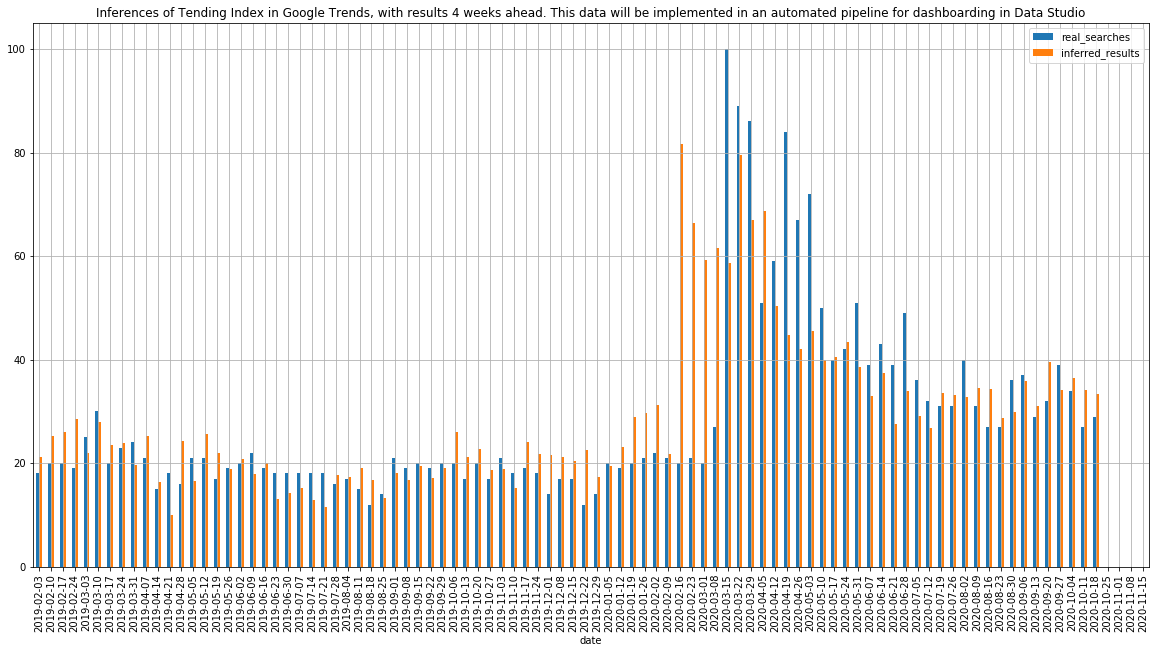

In [68]:
# visualization
result.plot(x="date",
            y=["real_searches","inferred_results"],
            figsize=(20,10), 
            kind="bar",
            title="Inferences of Tending Index in Google Trends, with results 4 weeks ahead. This data will be implemented in an automated pipeline for dashboarding in Data Studio",
            grid=True)

## CSV to append weekly the score

In [52]:
score = pd.DataFrame({"date": [max(df["date"])], 'score': [round(rfecv.score(X_train, target_train),4)]})
score.to_csv("input/weekly_score.csv")
score

,date,score
0,2020-11-15,0.8707


## CSV to overwrite weekly ranking of features by importance.

Of course there is a lot of room for improvement, but I'm glad the importance of features for the model looks coherent at first sight. Top 15 features, the ones selected by the model:

- erte = Record of Temporary Employment Regulation
- emergencia sanitaria = healthcare emegercy
- cáritas = a crhistian ONG helping the most vulnerable
- crecimiento económico = economical growth 
- videocall
- remote working
- Skype

In [53]:
# Ranking of how important are the following keywords to infer in Google searches in Spain
# the keyword "unemployment"
features=pd.DataFrame()
features["features"]=X.columns
features["top_important"]=rfecv.ranking_
features.sort_values(by=["top_important"], inplace=True)
features.reset_index(drop=True, inplace=True)
features.to_csv("input/ranking_of_features.csv")
features.head(50)
# with a linear regression the number of important features was reduced. It also had better performance.

,features,top_important
0,ejercito,1
1,badi,1
2,bullying,1
3,comedor social,1
4,uber eats,1
5,tinder,1
6,deshaucio,1
7,disney,1
8,divorcio,1
9,precio_vivienda,1
